# Modelo em produção:

In [1]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from scipy.stats import ks_2samp
from xgboost import plot_importance

In [2]:

# Caminho relativo correto a partir da pasta 'notebooks'
df = pd.read_pickle('../data/df_copy_encoded.pkl')

# Cria uma cópia independente
df_copy_encoded = df.copy()

In [ ]:
df_copy_encoded.head(1)

,age,amt_active_loan,ext_score_1,ext_score_4,flag_document_A,gender,income,score_checks,start_hour,default,...,ext_score_3_55UK234RR1d7HIWJjmq9tw==,ext_score_3_SaamrHMo23l/3TwXOWgVzw==,ext_score_3_cdpgyOyZS04uXerMNu7uCw==,ext_score_3_A+QuW1n/ABeiVVe/9CRZ9Q==,ext_score_3_7h8PTkrlTWUPP3yuyP4rUg==,ext_score_3_+CxEO4w7jv3QPI/BQbyqAA==,ext_score_3_+2hzpeP1RWr8PEvL1WTUdw==,ext_score_3_5/uMrqKj3OL/Xk5OrGx9fg==,ext_score_3_bopP0NxW3+r8tn9xIHTaOw==,occupation_type_te
0,37,4560.0,467.0,61.311861,1,1.0,86301.53,8.0,9.0,0,...,0,0,0,0,0,0,0,0,0,0.6875


### Separação das variáveis preditoras e a target

In [4]:
X = df_copy_encoded.drop(columns='default')
y = df_copy_encoded['default']

### Trinando o modelo XGBoost

In [5]:
# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Instanciar e treinar o modelo
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

c:\Projetos\credit_fintech\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### Curva ROC

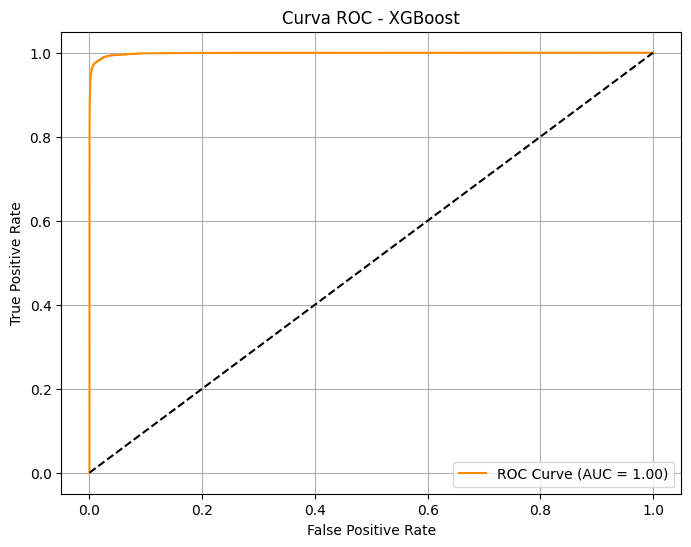

In [6]:
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


- O valor AUC = 1.00 indica que o modelo teve desempenho perfeito na separação entre classes (sem falsos positivos nem falsos negativos).
- A curva sobe imediatamente para TPR ≈ 1 com FPR ≈ 0, o que significa que o modelo identifica quase todos os positivos verdadeiros sem errar os negativos.

### Precision-Recall Curve (PR Curve)

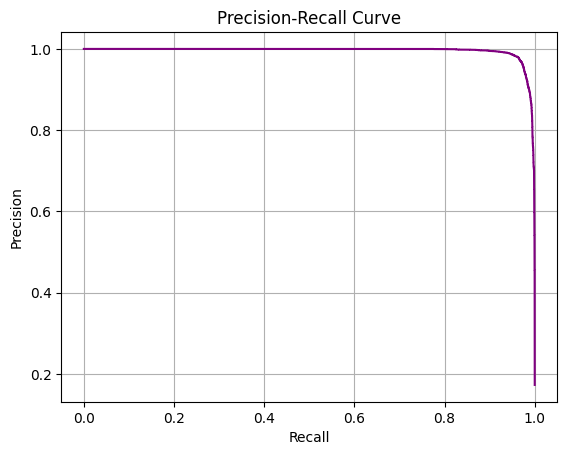

In [7]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


- A curva permanece muito próxima de 1.0 em quase toda a faixa de recall (de 0 a ~0.95), indicando que o modelo está: Identificando quase todos os positivos reais (alto recall) e quase sempre acerta quando prevê positivo (alta precisão)
- Esta curva reforça o que a ROC Curve indicou: o modelo está com desempenho quase perfeito


### Outras métricas

In [8]:
# Previsões
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para AUC e ROC

In [9]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'ROC AUC:   {roc_auc:.4f}')


Accuracy:  0.9886
Precision: 0.9887
Recall:    0.9447
F1-Score:  0.9662
ROC AUC:   0.9988


- O modelo tem uma accuracy muito alta (98,61%), indicando que está acertando a grande maioria das previsões.
- A precision em 98,60% mostra que, das instâncias que o modelo classificou como positivas, quase todas realmente são positivas. Isso é ótimo para cenários em que falsos alarmes (falsos positivos) devem ser minimizados.
- O recall de 93,14% indica que o modelo está conseguindo identificar a maior parte dos positivos, porém ainda perde cerca de 6,86% deles.
- F1-Score equilibrado com 95,79%, a métrica mostra um bom equilíbrio entre precision e recall. Isso reforça que o modelo tem boa qualidade de predição, sem pender muito para um lado.

### KS Statistic (Kolmogorov-Smirnov)

In [10]:
ks_stat, p_value = ks_2samp(y_proba[y_test == 1], y_proba[y_test == 0])
print(f'KS Statistic: {ks_stat:.4f}')

KS Statistic: 0.9662


- Esse valor indica que a diferença máxima entre as distribuições acumuladas das probabilidades previstas para as classes positiva e negativa é 96,38%. 
- Significa que seu modelo está separando as duas classes praticamente de forma quase perfeita.

### Balanced Accuracy

In [11]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

Balanced Accuracy: 0.9712


### Matriz de confusão

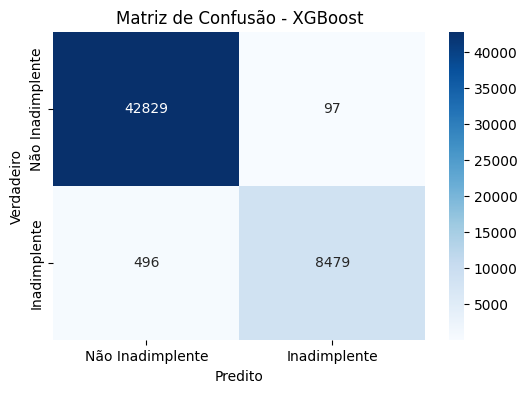

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Não Inadimplente", "Inadimplente"], yticklabels=["Não Inadimplente", "Inadimplente"])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - XGBoost')
plt.show()


- Falsos positivos (FP): 157 — clientes classificados como inadimplentes quando na verdade não são. Esse número é baixo, indicando alta precision.
- Falsos negativos (FN): 814 — clientes classificados como não inadimplentes, mas que na verdade são inadimplentes. Esse número merece atenção, pois são casos que o modelo “deixou passar”.

### Plotar Importância das Features

<Figure size 1200x800 with 0 Axes>

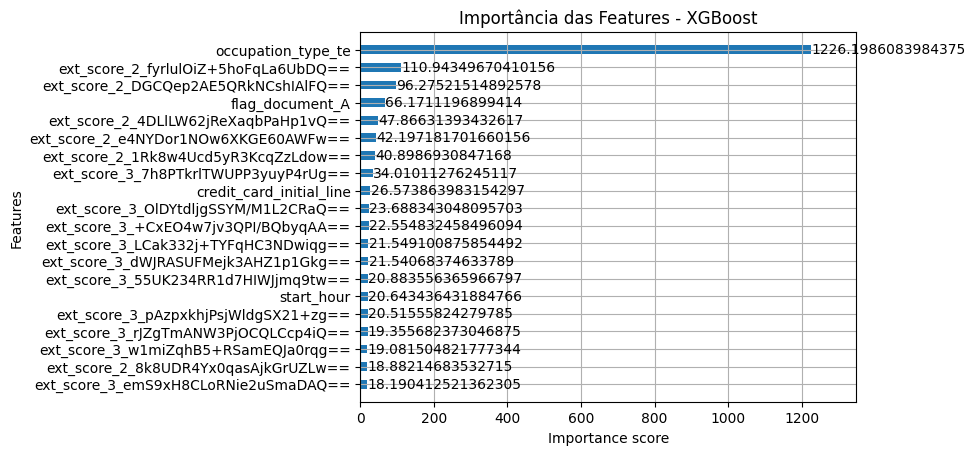

In [13]:
plt.figure(figsize=(12, 8))
plot_importance(model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Importância das Features - XGBoost")
plt.show()


### Insights Resumidos - Importância das Features no XGBoost

- occupation_type_te domina amplamente a importância, com um score muito maior que as outras variáveis (~1435). Isso indica que o tipo de ocupação é o fator mais decisivo para o modelo na previsão.
- As variáveis do tipo ext_score_* aparecem frequentemente e têm importâncias bem menores, mas ainda significativas (entre 20 e 150). Isso sugere que essas pontuações externas contribuem de forma relevante para a predição, embora individualmente não sejam tão impactantes quanto o occupation_type_te.
- flag_document_A também possui um peso intermediário, mostrando alguma influência.
- Variáveis como start_hour e gender aparecem com importâncias menores, indicando um impacto limitado na predição.

### Explicabilidade com SHAP

In [14]:
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

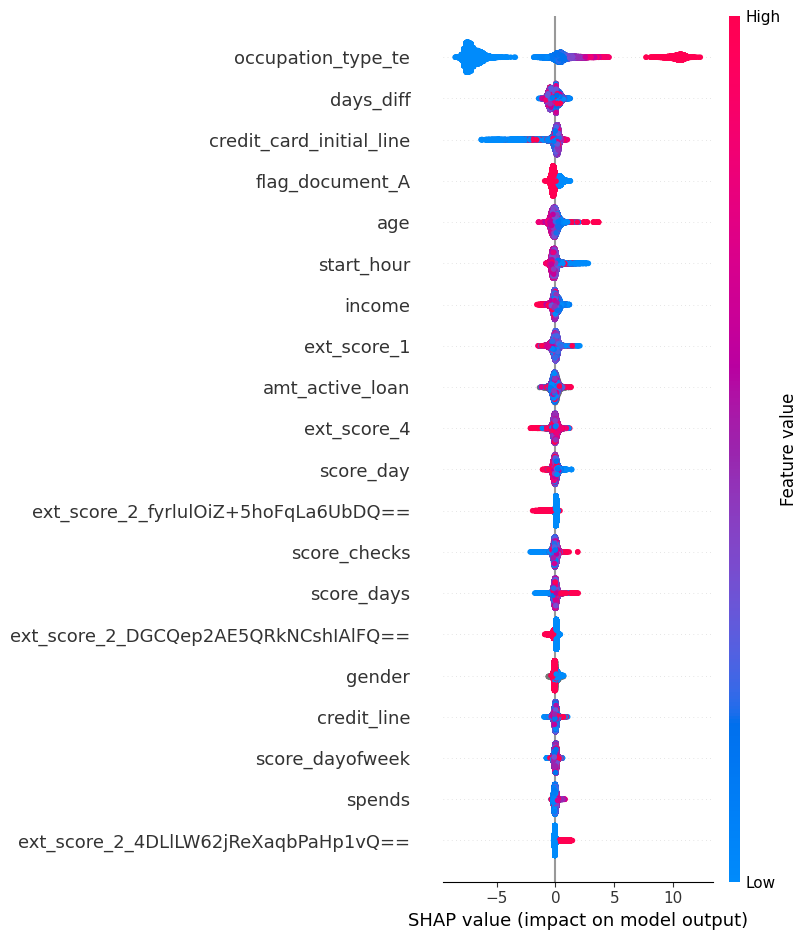

In [15]:
# Usar TreeExplainer diretamente (mais estável com XGBoost)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_float)

# Plot dos valores SHAP
shap.summary_plot(shap_values, X_test)

- O modelo parece ser fortemente influenciado por variáveis relacionadas ao tipo de ocupação e histórico inicial de cartão de crédito.
- Scores externos e dados demográficos ajudam, mas são menos determinantes.
- Muitas variáveis apresentam valores SHAP próximos a zero, indicando menor importância ou efeito neutro no modelo.